# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

2024-10-04 13:07:10.709904: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 13:07:10.710103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 13:07:10.862654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 13:07:11.133386: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 13:07:13.406398: W tensorflow/compiler/tf2

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)


Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:
total_words = len(tokenizer.word_index) + 1

Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [5]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [6]:
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [7]:
X, y = input_sequences[:, :-1], input_sequences[:, -1]


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [8]:
y = ku.to_categorical(y, num_classes=total_words)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Initialize the model
model = Sequential([
    # Embedding layer
    Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len - 1),

    # Bidirectional LSTM layer with 150 units
    Bidirectional(LSTM(150, return_sequences=True)),

    # Dropout layer with rate 0.2
    Dropout(0.2),

    # Second LSTM layer with 100 units
    LSTM(100),

    # Dense layer (Intermediate) with ReLU activation and L2 regularization
    Dense(total_words // 2, activation='relu', kernel_regularizer=l2(0.01)),

    # Output Dense layer with softmax activation
    Dense(total_words, activation='softmax')
])

2024-10-04 13:07:18.799428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 13:07:19.331180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 13:07:19.331514: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [11]:

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           337500    
                                                                 
 bidirectional (Bidirection  (None, 10, 300)           301200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1687)              170387    
                                                                 
 dense_1 (Dense)             (None, 3375)              5697000   
                                                        

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [13]:
# Train the model for 50 epochs
history = model.fit(X, y, epochs=100, verbose=1)


Epoch 1/100
484/484 [==============================] - 5s 11ms/step - loss: 4.4107 - accuracy: 0.1587
Epoch 2/100
484/484 [==============================] - 5s 11ms/step - loss: 4.3015 - accuracy: 0.1717
Epoch 3/100
484/484 [==============================] - 5s 11ms/step - loss: 4.1928 - accuracy: 0.1838
Epoch 4/100
484/484 [==============================] - 6s 12ms/step - loss: 4.0832 - accuracy: 0.1990
Epoch 5/100
484/484 [==============================] - 5s 11ms/step - loss: 3.9847 - accuracy: 0.2136
Epoch 6/100
484/484 [==============================] - 6s 12ms/step - loss: 3.8916 - accuracy: 0.2278
Epoch 7/100
484/484 [==============================] - 6s 12ms/step - loss: 3.7942 - accuracy: 0.2424
Epoch 8/100
484/484 [==============================] - 6s 12ms/step - loss: 3.6947 - accuracy: 0.2608
Epoch 9/100
484/484 [==============================] - 5s 11ms/step - loss: 3.5999 - accuracy: 0.2807
Epoch 10/100
484/484 [==============================] - 6s 11ms/step - loss: 3.506

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

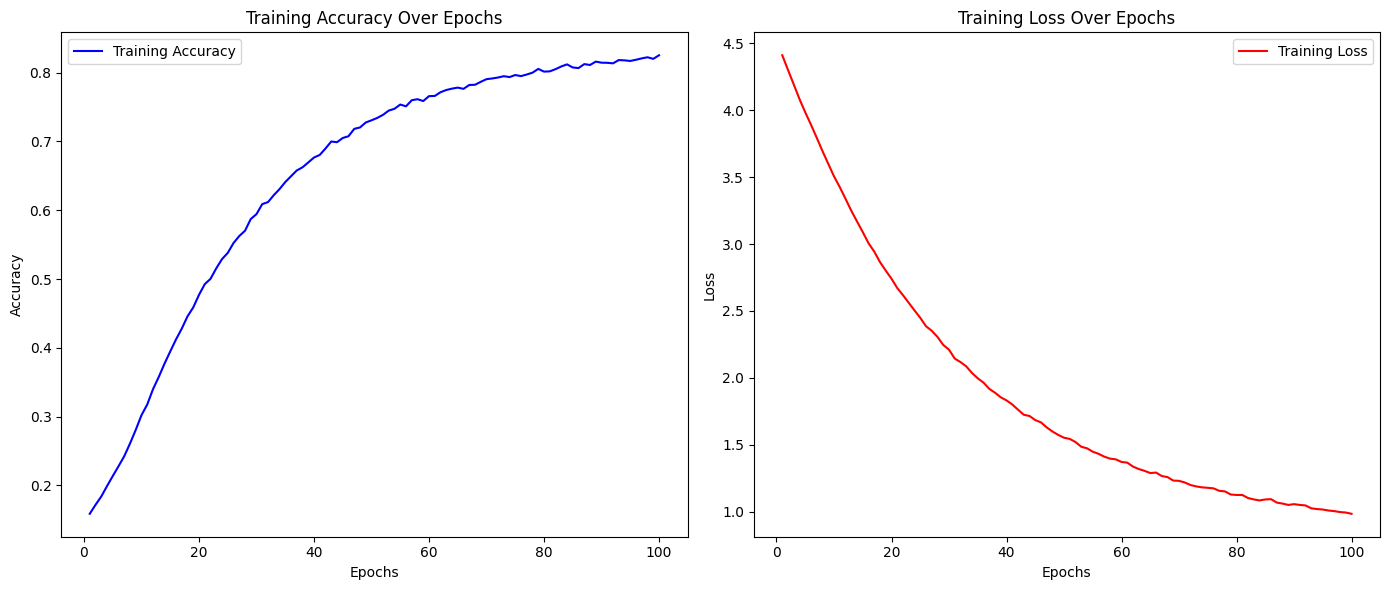

In [14]:
import matplotlib.pyplot as plt

# Extract accuracy and loss data from the history object
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot training accuracy over epochs
plt.figure(figsize=(14, 6))

# Subplot 1: Accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', color='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

# Subplot 2: Loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [16]:
seed_text = 'Everyday I wake up ready for nature but instead I need to go to work'
next_words = 300

Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [17]:
for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted)

    # Find the predicted word using the tokenizer's word index
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            output_word = word
            break

    # Append the predicted word to the seed text
    seed_text += " " + output_word

# Print the generated text
print(seed_text)

Everyday I wake up ready for nature but instead I need to go to work bear true life prove things back long date back sad sovereign dear o'er sit sit sit sit sit sit shown sit sit sit lie with new age alone back not last so dear true show thee back thee did mine change groan face so know not men thee words these strong wrong day had light lies crime decease date decays long hour light fire back sad jaws staineth brought of store first hate staineth light light brought with cross lease back sad best desert a chest lie with thee long light green wrong ill fire ' so last up alone back back lived lend them up back by alone shall boast how never know thee know call not most time's fell place age must still dwell ' speak place in me for men back lack alone was your 'will ' by ill back so may seem true bright stay new pride lack back sad wrong day made worse worse worse desired hell clears long rare grow back seen last lend things waste alone back now last alone so so dear change his brow prid

Experiment with at least 3 different seed_text strings and see what happens!

In [18]:
seed_text = 'I shall conquer the world of AI!'
next_words = 50

for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted)

    # Find the predicted word using the tokenizer's word index
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            output_word = word
            break

    # Append the predicted word to the seed text
    seed_text += " " + output_word

# Print the generated text
print(seed_text)

I shall conquer the world of AI! this large re survey fitted date long than last back sad riper up twain long date ' back sad minds back sad cross stay well bars in store with hell fitted date must live thence shown seen date bettering than new tell lend them new new last back long long


In [19]:
seed_text = 'How dare you defy humanity?'
next_words = 50

for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted)

    # Find the predicted word using the tokenizer's word index
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            output_word = word
            break

    # Append the predicted word to the seed text
    seed_text += " " + output_word

# Print the generated text
print(seed_text)

How dare you defy humanity? no precious despising in away the help of fair age exchanged bearing pleasure die ' prove men wrong day lived shall hell with back again worse worse seen growth now seen growth of ill back did seen outworn be fitted prove back sad lie with men ill on thee well


In [20]:
seed_text = 'Never will you cherish the joy of victory!'
next_words = 10

for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted)

    # Find the predicted word using the tokenizer's word index
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            output_word = word
            break

    # Append the predicted word to the seed text
    seed_text += " " + output_word

# Print the generated text
print(seed_text)

Never will you cherish the joy of victory! some place age brought in rest groan lies young thee
